** Initialization of spark **

In [1]:
import findspark
findspark.init()

from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import desc

spark = SparkSession.builder \
            .master('local') \
            .appName('hotels') \
            .getOrCreate()
            
sc = spark.sparkContext 

In [2]:
def mapByHotelName(row):
    key = row['Hotel Name']
    val = 1
    return (key,val)

def reduceByCount(val1, val2):
    return (val1 + val2)

hotels_num = 150

hotels_rdd = spark.read.csv('../input/Hotels_Data_Changed.csv',header=True).rdd
hotel_names_top150 = hotels_rdd \
            .map(mapByHotelName) \
            .reduceByKey(reduceByCount) \
            .sortBy(lambda x: x[1], ascending = False) \
            .map(lambda x: x[0]) \
            .take(hotels_num)
            
hotels_top = hotels_rdd.filter(lambda x: x['Hotel Name'] in hotel_names_top150)

In [3]:
def mapByCheckinDate(row):
    key = row['Checkin Date']
    val = 1
    return (key,val)

checkin_date_num = 40

checkin_top_keys = hotels_top \
            .map(mapByCheckinDate) \
            .reduceByKey(reduceByCount) \
            .sortBy(lambda x: x[1], ascending = False) \
            .map(lambda x: x[0]) \
            .take(checkin_date_num)
            
top_hotels_in_date = hotels_top.filter(lambda x: x['Checkin Date'] in checkin_top_keys)

In [4]:
def mapHotelDatesDiscountCode(row):
    key = (row['Hotel Name'],row['Checkin Date'],row['Discount Code'])
    val = float(row['Discount Price'])
    return (key,val)

def reduceByHotelAndCheckinDate(val1,val2):
    if val1 == -1:
        return val2
    elif val2 == -1:
        return val1
    else:
        return min(val1,val2)

def createAllKeys(hotels,dates,codes):
    names_keys = sc.parallelize(hotels)
    dates_keys = sc.parallelize(dates)
    codes_keys = sc.parallelize(codes)
    return names_keys.cartesian(dates_keys.cartesian(codes_keys)).map(lambda x: (x[0], x[1][0], x[1][1]))

hotels_date_price_missing_data = createAllKeys(hotel_names_top150,checkin_top_keys,['1','2','3','4']).map(lambda x: (x, -1))

hotels_date_price = \
        top_hotels_in_date \
                .map(mapHotelDatesDiscountCode)
            
hotels_date_price_all_values = sc.union([hotels_date_price_missing_data, hotels_date_price]).reduceByKey(reduceByHotelAndCheckinDate)
hotels_date_price_all_values = hotels_date_price_all_values.map(lambda x: (x[0][0], x[1])).groupByKey().mapValues(list)

In [29]:
def normalise(prices):
    filtered_prices = list(filter(lambda x: x != -1, prices))
    
    if len(filtered_prices) == 0:
        return prices
    
    max_price = max(filtered_prices)
    min_price = min(filtered_prices)
    
    diff = max_price - min_price
    
    arr = []
    for price in prices:
        if price == -1:
            arr.append(price)
        elif diff == 0:
            arr.append(0)
        else:
            arr.append(float(price - min_price) * 100/diff)
            
    return arr

normalised_hotels_prices = hotels_date_price_all_values.map(lambda x: (x[0], normalise(x[1])))
normalised_prices = normalised_hotels_prices.values()

In [48]:
from pyspark.mllib.clustering import BisectingKMeans, BisectingKMeansModel

k=hotels_num
model = BisectingKMeans().train(normalised_prices, k=k)
cost = model.computeCost(normalised_prices)
print("With K={}".format(k))
print("Within Set Sum of Squared Errors = " + str(cost))
print('--'*30)

With K=150
Within Set Sum of Squared Errors = 0.0
------------------------------------------------------------


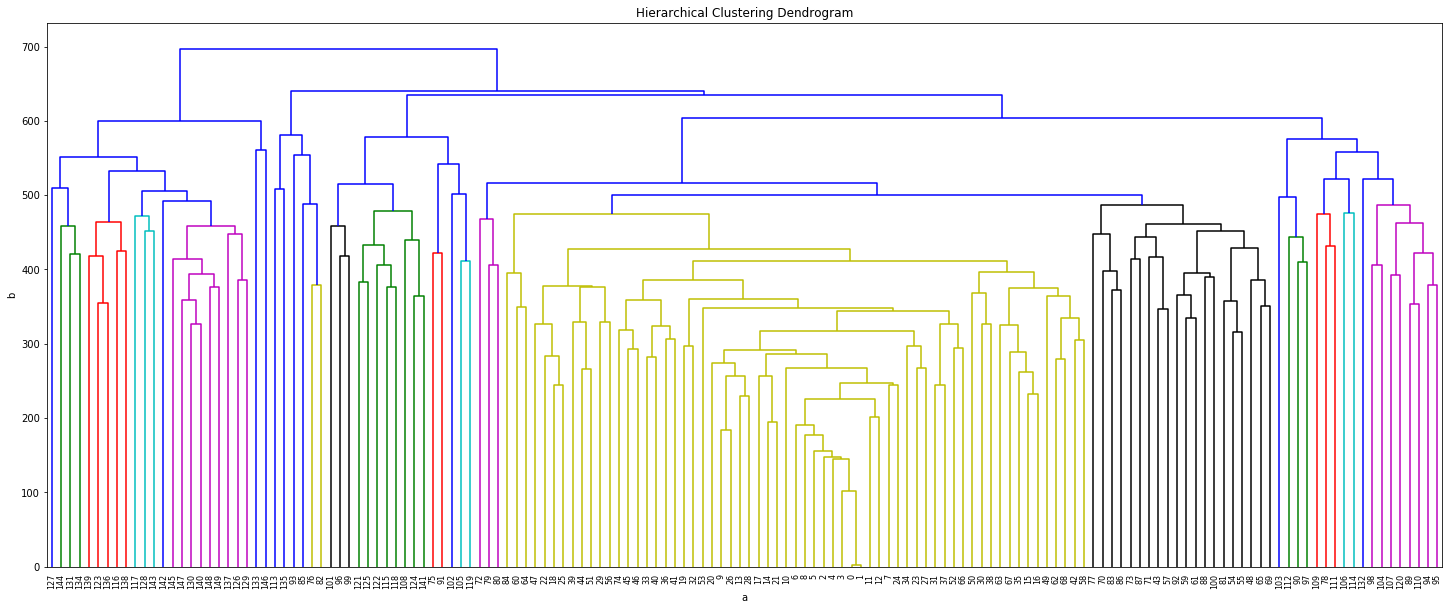

In [52]:
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram
from matplotlib import pyplot as plt

plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('a')
plt.ylabel('b')

dendrogram(
linkage(model.clusterCenters, method='complete'),
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
    truncate_mode='lastp',  # show only the last p merged clusters
    p=k,  # show only the last p merged clusters
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()